In [39]:
%matplotlib inline
#includes
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (20, 10)
#pytorch
import torch
import torchaudio
torch.cuda.is_available()

True

In [40]:
def Normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

In [41]:
#librosa for some audio processing
import librosa
import librosa.display
#soundfile for writing .wav files
import soundfile as sf


In [ ]:
#filename = os.path.join(folder, files[ file_n ])
#waveform, sample_rate = torchaudio.load(filename)

In [4]:
#list of species to loop over (ones to start with)

species = [
    ('American Robin', 281),
    ('American Crow', 20),
    ('American Goldfinch', 286),
    ('Bald Eagle', 68),
    ('Blue Jay', 182),
    ('Brown-headed Cowbird', 230),
    ('Carolina Chickadee', 53),
    ('Canada Goose', 238),
    ('Eastern Bluebird', 243)]
''',
    ('Indigo Bunting', 264),
    ('Mallard', 101),
    ('Purple Finch', 233),
    ('Red-winged Blackbird', 138), #file 72 is a good example
    ('Rose-breasted Grosbeak', 186), #file 10
    ('Tufted Titmouse', 78), #file 5 good example (file 0 bad sound at end file 4 bad at beginning)
    ('Scarlet Tanager', 29)
]'''

species_list = [spec for spec,n in species]
species_list

['American Robin',
 'American Crow',
 'American Goldfinch',
 'Bald Eagle',
 'Blue Jay',
 'Brown-headed Cowbird',
 'Carolina Chickadee',
 'Canada Goose',
 'Eastern Bluebird']

In [56]:
from scipy.signal import find_peaks

def FindPeaksInSample( wf_in, sample_rate, output=False ):
    waveform = Normalize( wf_in )
    waveform_np = waveform[0].t().numpy()
    wf_abs = np.abs( waveform_np )
    yabs_avg, yabs_max = np.average( wf_abs ), np.max( wf_abs )
    
    ymin, ymax = waveform.min(), waveform.max()

    fraction_of_max = 0.5625
    nsec_before = 0.5625
    nsec_after = nsec_before + 2*0.1625
    
    sr = sample_rate

    dist_before = sr*nsec_before #+/- n second #seperation of 0.5 seconds between peaks
    dist_after = sr*(nsec_after)
    
    #define peak finder parameters
    thresh = ymax.numpy()*fraction_of_max
    peak_seperation = nsec_before*sample_rate
    peaks, _ = find_peaks(waveform_np, height=thresh, distance=peak_seperation)
    if output:
        print('yabs_avg', yabs_avg, 'yabs_max', yabs_max)
        print('nsec after = ', nsec_after)
        print( f'+/-{nsec_before} seconds = dist before {nsec_before} and after = {nsec_after}' )

        #create a plot, don't plot the peaks if you don't find any...
        f, ax = plt.subplots()# figsize=(14,10) )
    
        try:
            if output:
                print('peaks', peaks)
                x_max_peak = waveform_np[peaks[0]]
                #xbox = peaks[0] - dist/2

                height, width = 1.1*(ymax-ymin), dist_before+dist_after
                SF = 1.1

                ax.fill_between( (peaks[0]-dist_before, peaks[0]+dist_after), y1=(SF*ymax, SF*ymax),
                                y2=(SF*ymin, SF*ymin), color='black', alpha=0.25 )
                ax.plot(peaks, waveform_np[peaks], 'x', color='orange')
                ax.set_xlabel('samples', fontsize=14)
                ax.set_ylabel('amplitude', fontsize=14)
                ax.set_title('Scarlet Tanager/321431.mp3', fontsize=18)

        except Exception as e: 
            print('exception', e)
            print('no peaks found!')

          
        ax.plot(waveform_np, color='blue')
        ax.plot(np.zeros_like(waveform_np)+thresh, '--', color='gray');
        plt.show()
    return peaks, nsec_before, nsec_after



yabs_avg 0.018652694 yabs_max 1.0
nsec after =  0.8875
+/-0.5625 seconds = dist before 0.5625 and after = 0.8875
peaks [ 59459 134446 200666 265863 363009 436005 595123]


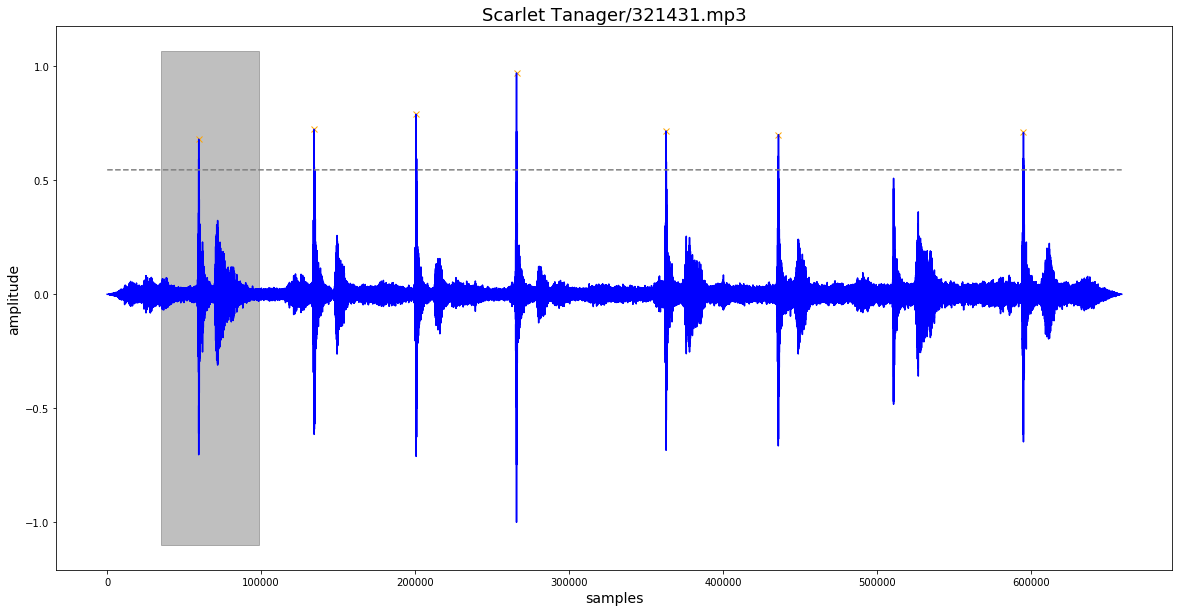

(array([ 59459, 134446, 200666, 265863, 363009, 436005, 595123]),
 0.5625,
 0.8875)

In [57]:
#to create plot for presentation
import torchaudio

filename = '/home/chris/Documents/Insight2020/examples/birdcalls/Scarlet Tanager/321431.mp3'
waveform, sample_rate = torchaudio.load(filename)
wf_np = waveform[0].t().numpy()
FindPeaksInSample( waveform, sample_rate, output=True )

In [31]:
os.getcwd()

'/home/chris/Documents/Insight2020/examples'

In [ ]:
#exmaple of finding peaks
path, files = GetFilesForSpecies( spec_name='American Robin')
   
filename = f'{path}/{file}'
print(filename)
waveform, sample_rate = torchaudio.load(filename)
peaks, before, after = FindPeaksInSample( waveform, sample_rate )
FindPeaksInSample( wf_np, sample_rate, output=True )

In [6]:
#writing sub-soundfiles from the original, broken at the interseting peaks
#choose how long you want the new clip to be (2 seconds for example)
#this time must be translated into "samples" units

def CutClip( original_audio, peaks, sample_rate, sec_before, sec_after, species, filenumber, savefolder='cutclips/' ):
    '''cut the clip into a sub-clip at each of the peak positions found'''
    #peak = peaks[2]  #test line, put into loop of all peaks after
    sample_before = sample_rate*sec_before #num of samples after peak
    sample_after = sample_rate*sec_after #num of smaples before peak
    length = sec_before + sec_after  #sum of cut before and after, in seconds
    total = sample_rate * length  #total number of smaples to cut
    #length_in_samples = sample_rate * sec_to_cut
    ##print(f'to cut {length} seconds, the total will be {total} samples\n')
    ##print('begin looping through peaks:')
    for j,peak in enumerate(peaks):
        
        start = peak - sample_before
        end = peak + sample_after
        print( f'\nfor the peak at {peak}, cut from {start} to {end}' )
        if start<0:
            print('start<0...Can not create a clip before the start of the file!')
            ##print('potentially shift the start of the clip over the number of samples it is over the edge\
            ##...but just throw it out for now')
        elif end > original_audio.shape[1]:
            print('end > len(original_audio)...Can not create a clip that ends after the end of the file!')
        else:
            ##print('good index values to write clip!')
            #write a new .wav file, in the sub-dir for that species
            newfilename = f'{savefolder}{spec_name}_{filenumber}_{j}.wav'
            print(newfilename)
            y = np.asfortranarray( original_audio[0].numpy() ) #convert to numpy array so soundfile can handle it
            ##print( 'orig.shape', original_audio.shape, 'y.shape', y.shape )
            #sf.write('testfile.wav', y[int(peak - sample_before): int(peak + sample_after) ], samplerate=sample_rate)  #write the file 
            sf.write(newfilename, y[ int(peak - sample_before): int(peak + sample_after) ], samplerate=sample_rate)  #write the file      
            #break

#orig =  np.array([ np.arange( 1, 100001 ) , np.arange( 2, 100001 ) ])

In [ ]:

#sf.write( , original_audio[:, int(peak - sample_before): int(peak + sample_after) ], samplerate=sample_rate) 

In [1]:
import os
top_folder = 'birdcalls/'
filetype = 'mp3'
folders = os.listdir(top_folder)
os.getcwd()
folders

['Cuban Emerald',
 'Olive-sided Flycatcher',
 "Couch's Kingbird",
 'Yellow-headed Blackbird',
 'Mourning Dove',
 'Summer Tanager',
 'Western Sandpiper',
 '(?)',
 'Green Heron',
 'Common Redpoll',
 'Least Flycatcher',
 'Black-throated Green Warbler',
 'Chipping Sparrow',
 'Purple Martin',
 'Yellow-crowned Night Heron',
 'American Golden Plover',
 'Spruce Grouse',
 'White-breasted Nuthatch',
 'Upland Sandpiper',
 'Smooth-billed Ani',
 'American Crow',
 'Least Tern',
 'American Black Duck',
 'Long-billed Dowitcher',
 'Solitary Sandpiper',
 'American Redstart',
 'Calliope Hummingbird',
 "Wilson's Snipe",
 'Blackburnian Warbler',
 'Scarlet Tanager',
 'Orange-crowned Warbler',
 'Swallow-tailed Kite',
 'American Oystercatcher',
 'Antillean Nighthawk',
 'Mottled Duck',
 'American Kestrel',
 "Wilson's Plover",
 'Canada Warbler',
 'Western Osprey',
 'Common Merganser',
 'Yellow Rail',
 'Baltimore Oriole',
 'Cedar Waxwing',
 'Painted Bunting',
 'Louisiana Waterthrush',
 'Semipalmated Plover',
 'B

In [24]:
#determine the number of files, and approximate length,
##for the files available for each species
#this is to determine which species to inclue in the model
import pandas as pd
import matplotlib.pyplot as plt


def GetNumPerSpecies( topfolder='birdcalls/' ):
    filetype = 'mp3'
    folders = os.listdir(topfolder)
    d = {}
    sizes = {}
    both = {}
    counts = {}
    for fold in folders:
        
        files = os.listdir( os.path.join( topfolder, fold ) )
        d[ fold ] = files
        counts[ fold ] = len( d[ fold ] )
        size = 0
        for file in files:
            size += os.path.getsize( os.path.join( topfolder, fold, file )  )
            
        sizes[ fold ] = size
        #print( fold, sizes[fold] )
        
        both[fold] = counts[fold], sizes[fold]
    #for k,item in d.items():
    #    counts[k] = len( d[k] )
        
        #print(k, counts[k])
    return d, counts, sizes, both
        
d, counts, sizes, both = GetNumPerSpecies()

#both is (num_files, sizes)
#sortby 0 or 1 to detemine order of new dataframe
s_both = list( sorted( both.items() , key=lambda l: l[1][0] , reverse=True ) )
s_both = [(s[0], s[1][0], s[1][1]) for s in s_both]
df_both = pd.DataFrame( s_both  )
df_both.columns = 'species files total_space'.split()
df_both.set_index('species', drop=True, inplace=True)


s_counts = list( sorted( counts.items() , key=lambda l: l[1] , reverse=True ) )
df_c = pd.DataFrame( s_counts )
df_c.columns = 'species', 'number of files'
df_c.set_index('species', drop=True, inplace=True)

s_sizes = list( sorted( sizes.items() , key=lambda l: l[1] , reverse=True ) )    
df_s = pd.DataFrame( s_sizes )
df_s.columns = 'species', 'sizes'
#df.plot.hist( bins = 24, alpha=0.6 )
df_s.set_index('species', drop=True, inplace=True)


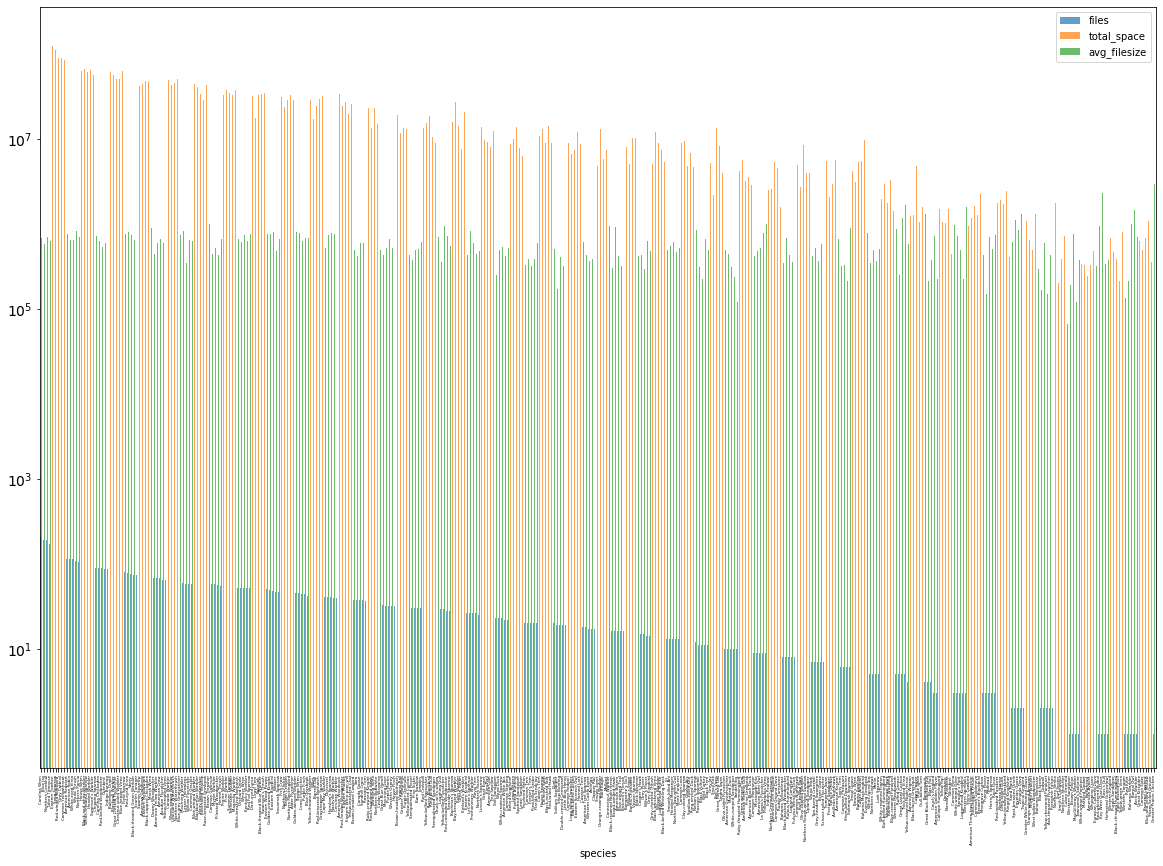

In [7]:
df_both['avg_filesize'] = df_both.total_space/df_both.files
df_both.head()

ax = df_both.plot.bar(figsize=(20, 14), fontsize=4, alpha=0.7)
ax.set_yscale('log')
for tick in ax.get_yticklabels():
    tick.set_fontsize(14)
    

plt.savefig( 'both_bar.pdf',  encoding='pdf' )

"\n#f,ax = plt.subplots( figsize=(20,14) )\nax = df_s.plot.bar( figsize=(10,8) , fontsize=4 )\nax.set_yscale('log')\nplt.savefig( 'sizes_bar.pdf',  encoding='pdf' )\n#ax.set_xticklabels( fontsize=4 )\nfor tick in ax.get_yticklabels():\n    tick.set_fontsize(10)\n    \n#use a hist for both  \nax = df_both.plot.bar(figsize=(20,14), fontsize=4, alpha=0.7)\nax.set_yscale('log')\nfor tick in ax.get_yticklabels():\n    tick.set_fontsize(10)\n"

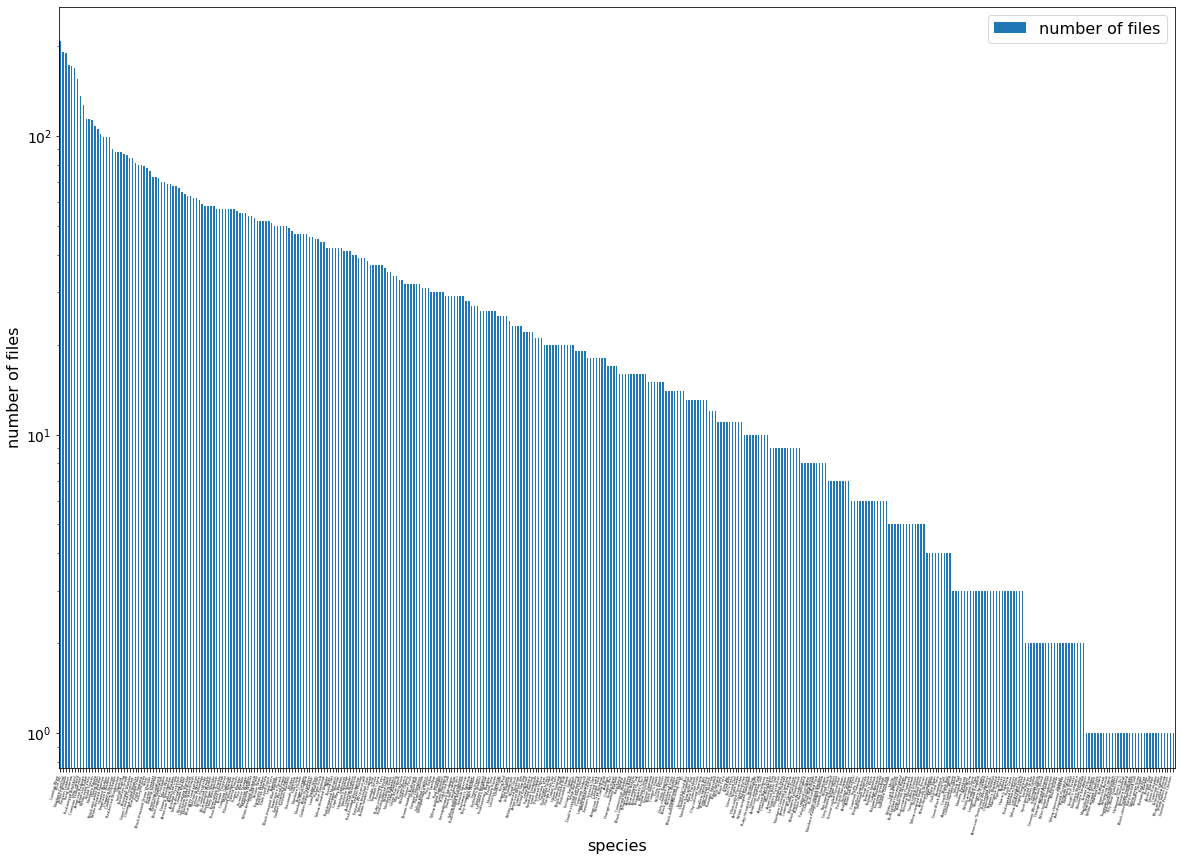

In [12]:
#create plots of the distributions

#f,ax = plt.subplots( figsize=(20,14) )
ax = df_c.plot.bar( figsize=(20,14) , fontsize=4 )
ax.set_yscale('log')
plt.legend( fontsize=16 )
#ax.set_xticklabels( fontsize=4 )
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=75, ha='right', fontsize=3.5)
ax.set_xlabel('species', fontsize=16 )
ax.set_ylabel('number of files', fontsize=16 )
for tick in ax.get_yticklabels():
    tick.set_fontsize(14)
    
plt.savefig( 'species_bar.pdf',  encoding='pdf' )
'''
#f,ax = plt.subplots( figsize=(20,14) )
ax = df_s.plot.bar( figsize=(10,8) , fontsize=4 )
ax.set_yscale('log')
plt.savefig( 'sizes_bar.pdf',  encoding='pdf' )
#ax.set_xticklabels( fontsize=4 )
for tick in ax.get_yticklabels():
    tick.set_fontsize(10)
    
#use a hist for both  
ax = df_both.plot.bar(figsize=(20,14), fontsize=4, alpha=0.7)
ax.set_yscale('log')
for tick in ax.get_yticklabels():
    tick.set_fontsize(10)
'''

In [26]:
d

{'Cuban Emerald': ['205925.mp3'],
 'Olive-sided Flycatcher': ['444962.mp3',
  '54599.mp3',
  '466920.mp3',
  '83555.mp3',
  '466919.mp3',
  '260215.mp3',
  '247863.mp3',
  '104099.mp3',
  '181166.mp3',
  '186316.mp3'],
 "Couch's Kingbird": ['210753.mp3', '210752.mp3', '358192.mp3'],
 'Yellow-headed Blackbird': ['325752.mp3', '43419.mp3'],
 'Mourning Dove': ['476933.mp3',
  '138056.mp3',
  '130937.mp3',
  '179637.mp3',
  '130936.mp3',
  '389084.mp3',
  '407859.mp3',
  '391151.mp3',
  '97361.mp3',
  '412632.mp3',
  '430095.mp3',
  '187613.mp3',
  '153645.mp3',
  '53901.mp3',
  '31138.mp3',
  '190449.mp3',
  '128006.mp3',
  '179721.mp3',
  '83747.mp3',
  '153652.mp3',
  '97363.mp3',
  '177295.mp3',
  '141215.mp3',
  '318601.mp3',
  '57207.mp3',
  '134188.mp3',
  '83426.mp3',
  '71560.mp3',
  '100197.mp3',
  '451916.mp3',
  '97362.mp3',
  '404203.mp3'],
 'Summer Tanager': ['234566.mp3',
  '20574.mp3',
  '178216.mp3',
  '103626.mp3',
  '388587.mp3',
  '55198.mp3',
  '425988.mp3',
  '500352.

In [25]:
df_c.head(20)

,number of files
species,
Carolina Wren,207
Blue Jay,191
Northern Cardinal,190
Tufted Titmouse,172
Eastern Towhee,171
Song Sparrow,169
Red-winged Blackbird,155
Grey Catbird,136
Common Yellowthroat,127


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def GetNumPerSpecies( topfolder='birdcalls/' ):
    filetype = 'mp3'
    folders = os.listdir(topfolder)
    d = {}
    sizes = {}
    for fold in folders:
        truepath = os.path.join( topfolder, fold )
        files = os.listdir( truepath )
        d[ fold ] = files
        size = 0
        for file in files:
            size += os.path.getsize( truepath )
            
        sizes[ fold ] = size
        print( fold, sizes[fold] )
    
    counts = {}
    
    for k,item in d.items():
        counts[k] = len( d[k] )
        
        #print(k, counts[k])
    return d, counts, sizes, both
        
d, counts, sizes = GetNumPerSpecies()
s_counts = list( sorted( counts.items() , key=lambda l: l[1] , reverse=True ) )
s_sizes = list( sorted( sizes.items() , key=lambda l: l[1] , reverse=True ) )
df = pd.DataFrame( s_counts )
#df.plot.hist( bins = 24, alpha=0.6 )
df.columns = 'species', 'counts'
df.set_index('species', drop=True, inplace=True)
#f,ax = plt.subplots( figsize=(20,14) )
ax = df.plot.bar( figsize=(20,14) , fontsize=4 )
plt.savefig( 'species_bar.pdf',  encoding='pdf', )
#ax.set_xticklabels( fontsize=4 )
for tick in ax.get_yticklabels():
    tick.set_fontsize(10)

Cuban Emerald 4096
Olive-sided Flycatcher 40960
Couch's Kingbird 12288
Yellow-headed Blackbird 8192
Mourning Dove 131072
Summer Tanager 221184
Western Sandpiper 4096
(?) 53248
Green Heron 106496
Common Redpoll 73728
Least Flycatcher 180224
Black-throated Green Warbler 299008
Chipping Sparrow 360448
Purple Martin 131072
Yellow-crowned Night Heron 16384
American Golden Plover 12288
Spruce Grouse 24576
White-breasted Nuthatch 212992
Upland Sandpiper 28672
Smooth-billed Ani 53248
American Crow 274432
Least Tern 204800
American Black Duck 36864
Long-billed Dowitcher 73728
Solitary Sandpiper 77824
American Redstart 466944
Calliope Hummingbird 12288
Wilson's Snipe 61440
Blackburnian Warbler 233472
Scarlet Tanager 299008
Orange-crowned Warbler 65536
Swallow-tailed Kite 49152
American Oystercatcher 40960
Antillean Nighthawk 24576
Mottled Duck 40960
American Kestrel 24576
Wilson's Plover 57344
Canada Warbler 258048
Western Osprey 131072
Common Merganser 36864
Yellow Rail 12288
Baltimore Oriole 3

ValueError: too many values to unpack (expected 3)

In [13]:
def GetFolderNumberByName( spec_name = 'American Robin' ):
    '''get the folder number'''
    #spec_name = 'American Robin'
    found_num = [n for name, n in zip( folders, range(len(folders)) ) if name == spec_name]
    ##print('\n', spec_name == folders[found_num[0]], 'name found', folders[found_num[0]], 'folder number', found_num )
    return found_num[0]

def GetFilesForSpecies( spec_name ):
    nfold = GetFolderNumberByName( spec_name )
    folder =folders[nfold]
    path = ''.join( (top_folder, folder) )
    files = [ file for file in os.listdir(path) if filetype in file ]
    if spec_name == 'Scarlet Tanager':
        ##print(files)
        files.remove( '375269.mp3' )
        ##print(files, '\n')
    return path, files
    
def LoopOverFiles( path, files, spec_name, save_folder='cutclips/', cutclips=True ):
    '''for each file in the file list:
    load the waveform, call the peak finder function
    then for each peak, split the file into new files and store them in the '''
    for i,file in enumerate(files):
        filename = f'{path}/{file}'
        ##print(filename)
        try:
            waveform, sample_rate = torchaudio.load(filename)
            peaks, before, after = FindPeaksInSample( waveform, sample_rate )
            ##print('file', i, peaks, '\n')
            #function to cut clips into smaller samples
            if cutclips:
                CutClip( original_audio=waveform, peaks=peaks, sample_rate=sample_rate, sec_before=before,
                        sec_after=after, species=spec_name, filenumber=i, savefolder='cutclips/' )
        except Exception as e:
            print( 'exception', e )
        #break




In [15]:
#loop for single species
spec_name = species_list[0] #'American Robin' 
print( 'species in', spec_name)

path, files = GetFilesForSpecies( spec_name=spec_name )
LoopOverFiles( path, files, spec_name)
#LoopThroughSpecies( species_list=species_list )


species in American Robin

for the peak at 9652, cut from -15154.25 to 48790.75
start<0...Can not create a clip before the start of the file!

for the peak at 88612, cut from 63805.75 to 127750.75
cutclips/American Robin_0_1.wav

for the peak at 276593, cut from 251786.75 to 315731.75
cutclips/American Robin_0_2.wav

for the peak at 539229, cut from 514422.75 to 578367.75
cutclips/American Robin_0_3.wav

for the peak at 619629, cut from 594822.75 to 658767.75
cutclips/American Robin_0_4.wav

for the peak at 645760, cut from 620953.75 to 684898.75
cutclips/American Robin_0_5.wav

for the peak at 672334, cut from 647527.75 to 711472.75
cutclips/American Robin_0_6.wav

for the peak at 720542, cut from 695735.75 to 759680.75
cutclips/American Robin_0_7.wav

for the peak at 831138, cut from 806331.75 to 870276.75
cutclips/American Robin_0_8.wav

for the peak at 1136039, cut from 1111232.75 to 1175177.75
cutclips/American Robin_0_9.wav

for the peak at 1166003, cut from 1141196.75 to 1205141


for the peak at 73553, cut from 46553.0 to 116153.0
cutclips/American Robin_8_0.wav

for the peak at 103917, cut from 76917.0 to 146517.0
cutclips/American Robin_8_1.wav

for the peak at 548895, cut from 521895.0 to 591495.0
cutclips/American Robin_8_2.wav

for the peak at 5994, cut from -21006.0 to 48594.0
start<0...Can not create a clip before the start of the file!

for the peak at 524313, cut from 497313.0 to 566913.0
cutclips/American Robin_9_1.wav

for the peak at 557003, cut from 530003.0 to 599603.0
cutclips/American Robin_9_2.wav

for the peak at 591063, cut from 564063.0 to 633663.0
cutclips/American Robin_9_3.wav

for the peak at 640462, cut from 613462.0 to 683062.0
cutclips/American Robin_9_4.wav

for the peak at 672503, cut from 645503.0 to 715103.0
cutclips/American Robin_9_5.wav

for the peak at 705066, cut from 678066.0 to 747666.0
cutclips/American Robin_9_6.wav

for the peak at 753850, cut from 726850.0 to 796450.0
cutclips/American Robin_9_7.wav

for the peak at 78


for the peak at 638923, cut from 614116.75 to 678061.75
cutclips/American Robin_18_0.wav

for the peak at 39222, cut from 12222.0 to 81822.0
cutclips/American Robin_19_0.wav

for the peak at 105921, cut from 78921.0 to 148521.0
cutclips/American Robin_19_1.wav

for the peak at 143369, cut from 116369.0 to 185969.0
cutclips/American Robin_19_2.wav

for the peak at 201080, cut from 174080.0 to 243680.0
cutclips/American Robin_19_3.wav

for the peak at 250907, cut from 223907.0 to 293507.0
cutclips/American Robin_19_4.wav

for the peak at 324953, cut from 297953.0 to 367553.0
cutclips/American Robin_19_5.wav

for the peak at 140460, cut from 115653.75 to 179598.75
cutclips/American Robin_20_0.wav

for the peak at 188272, cut from 163465.75 to 227410.75
cutclips/American Robin_20_1.wav

for the peak at 216729, cut from 191922.75 to 255867.75
cutclips/American Robin_20_2.wav

for the peak at 378249, cut from 353442.75 to 417387.75
cutclips/American Robin_20_3.wav

for the peak at 426587, c


for the peak at 19105, cut from -7895.0 to 61705.0
start<0...Can not create a clip before the start of the file!

for the peak at 3089, cut from -21717.25 to 42227.75
start<0...Can not create a clip before the start of the file!

for the peak at 2309537, cut from 2284730.75 to 2348675.75
cutclips/American Robin_29_1.wav

for the peak at 2371785, cut from 2346978.75 to 2410923.75
cutclips/American Robin_29_2.wav

for the peak at 70505, cut from 45698.75 to 109643.75
cutclips/American Robin_30_0.wav

for the peak at 879594, cut from 852594.0 to 922194.0
cutclips/American Robin_31_0.wav

for the peak at 2141922, cut from 2114922.0 to 2184522.0
cutclips/American Robin_31_1.wav

for the peak at 3087163, cut from 3060163.0 to 3129763.0
cutclips/American Robin_31_2.wav

for the peak at 68921, cut from 44114.75 to 108059.75
cutclips/American Robin_32_0.wav

for the peak at 215848, cut from 191041.75 to 254986.75
cutclips/American Robin_32_1.wav

for the peak at 365371, cut from 340564.75 to 4


for the peak at 36722, cut from 11915.75 to 75860.75
cutclips/American Robin_44_0.wav

for the peak at 437517, cut from 412710.75 to 476655.75
cutclips/American Robin_44_1.wav

for the peak at 613345, cut from 588538.75 to 652483.75
cutclips/American Robin_44_2.wav

for the peak at 1279965, cut from 1255158.75 to 1319103.75
cutclips/American Robin_44_3.wav

for the peak at 1564106, cut from 1539299.75 to 1603244.75
cutclips/American Robin_44_4.wav

for the peak at 243388, cut from 218581.75 to 282526.75
cutclips/American Robin_45_0.wav

for the peak at 274231, cut from 249424.75 to 313369.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 673271, cut from 648464.75 to 712409.75
cutclips/American Robin_46_0.wav

for the peak at 750652, cut from 725845.75 to 789790.75
cutclips/American Robin_46_1.wav

for the peak at 950553, cut from 925746.75 to 989691.75
cutclips/American Robin_46_2.wav

for the peak at 1014788, cut from 989981.7


for the peak at 467050, cut from 442243.75 to 506188.75
cutclips/American Robin_61_6.wav

for the peak at 588570, cut from 563763.75 to 627708.75
cutclips/American Robin_61_7.wav

for the peak at 614688, cut from 589881.75 to 653826.75
cutclips/American Robin_61_8.wav

for the peak at 641979, cut from 617172.75 to 681117.75
cutclips/American Robin_61_9.wav

for the peak at 16821, cut from -7985.25 to 55959.75
start<0...Can not create a clip before the start of the file!

for the peak at 74534, cut from 49727.75 to 113672.75
cutclips/American Robin_62_1.wav

for the peak at 133771, cut from 108964.75 to 172909.75
cutclips/American Robin_62_2.wav

for the peak at 176754, cut from 151947.75 to 215892.75
cutclips/American Robin_62_3.wav

for the peak at 225651, cut from 200844.75 to 264789.75
cutclips/American Robin_62_4.wav

for the peak at 268823, cut from 244016.75 to 307961.75
cutclips/American Robin_62_5.wav

for the peak at 369924, cut from 345117.75 to 409062.75
cutclips/American R


for the peak at 1859707, cut from 1832707.0 to 1902307.0
cutclips/American Robin_72_21.wav

for the peak at 2002518, cut from 1975518.0 to 2045118.0
cutclips/American Robin_72_22.wav

for the peak at 2032266, cut from 2005266.0 to 2074866.0
cutclips/American Robin_72_23.wav

for the peak at 2062841, cut from 2035841.0 to 2105441.0
cutclips/American Robin_72_24.wav

for the peak at 2123381, cut from 2096381.0 to 2165981.0
cutclips/American Robin_72_25.wav

for the peak at 2304976, cut from 2277976.0 to 2347576.0
cutclips/American Robin_72_26.wav

for the peak at 2337277, cut from 2310277.0 to 2379877.0
cutclips/American Robin_72_27.wav

for the peak at 2368239, cut from 2341239.0 to 2410839.0
cutclips/American Robin_72_28.wav

for the peak at 2594331, cut from 2567331.0 to 2636931.0
cutclips/American Robin_72_29.wav

for the peak at 86323, cut from 61516.75 to 125461.75
cutclips/American Robin_73_0.wav

for the peak at 139872, cut from 115065.75 to 179010.75
cutclips/American Robin_73_


for the peak at 231022, cut from 204022.0 to 273622.0
cutclips/American Robin_79_0.wav

for the peak at 369068, cut from 342068.0 to 411668.0
cutclips/American Robin_79_1.wav

for the peak at 491872, cut from 464872.0 to 534472.0
cutclips/American Robin_79_2.wav

for the peak at 636803, cut from 609803.0 to 679403.0
cutclips/American Robin_79_3.wav

for the peak at 782231, cut from 755231.0 to 824831.0
cutclips/American Robin_79_4.wav

for the peak at 917798, cut from 890798.0 to 960398.0
cutclips/American Robin_79_5.wav

for the peak at 1047315, cut from 1020315.0 to 1089915.0
cutclips/American Robin_79_6.wav

for the peak at 1215373, cut from 1188373.0 to 1257973.0
cutclips/American Robin_79_7.wav

for the peak at 1332855, cut from 1305855.0 to 1375455.0
cutclips/American Robin_79_8.wav

for the peak at 1578892, cut from 1551892.0 to 1621492.0
cutclips/American Robin_79_9.wav

for the peak at 1679879, cut from 1652879.0 to 1722479.0
cutclips/American Robin_79_10.wav

for the peak at


for the peak at 150520, cut from 125713.75 to 189658.75
cutclips/American Robin_88_0.wav

for the peak at 637877, cut from 613070.75 to 677015.75
cutclips/American Robin_88_1.wav

for the peak at 5248, cut from -19558.25 to 44386.75
start<0...Can not create a clip before the start of the file!

for the peak at 103445, cut from 78638.75 to 142583.75
cutclips/American Robin_89_1.wav

for the peak at 129486, cut from 104679.75 to 168624.75
cutclips/American Robin_89_2.wav

for the peak at 923807, cut from 899000.75 to 962945.75
cutclips/American Robin_89_3.wav

for the peak at 107363, cut from 82556.75 to 146501.75
cutclips/American Robin_90_0.wav

for the peak at 134755, cut from 109948.75 to 173893.75
cutclips/American Robin_90_1.wav

for the peak at 210972, cut from 186165.75 to 250110.75
cutclips/American Robin_90_2.wav

for the peak at 379547, cut from 354740.75 to 418685.75
cutclips/American Robin_90_3.wav

for the peak at 571911, cut from 547104.75 to 611049.75
cutclips/American R


for the peak at 1107501, cut from 1082694.75 to 1146639.75
cutclips/American Robin_100_0.wav

for the peak at 495625, cut from 470818.75 to 534763.75
cutclips/American Robin_101_0.wav

for the peak at 912960, cut from 888153.75 to 952098.75
cutclips/American Robin_101_1.wav

for the peak at 1171827, cut from 1147020.75 to 1210965.75
cutclips/American Robin_101_2.wav

for the peak at 1357531, cut from 1332724.75 to 1396669.75
cutclips/American Robin_101_3.wav

for the peak at 1426750, cut from 1401943.75 to 1465888.75
cutclips/American Robin_101_4.wav

for the peak at 154577, cut from 129770.75 to 193715.75
cutclips/American Robin_102_0.wav

for the peak at 279721, cut from 254914.75 to 318859.75
cutclips/American Robin_102_1.wav

for the peak at 529456, cut from 504649.75 to 568594.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 42041, cut from 17234.75 to 81179.75
cutclips/American Robin_103_0.wav

for the peak at 143471, cut

In [14]:
#repeat for robin
for i in range( 2, len(species_list) ):
    spec_name = species_list[i] #'American Robin' 
    print( 'species in', spec_name)

    path, files = GetFilesForSpecies( spec_name=spec_name )
    LoopOverFiles( path, files, spec_name)
    #LoopThroughSpecies( species_list=species_list )

species in American Goldfinch

for the peak at 22280, cut from -4720.0 to 64880.0
start<0...Can not create a clip before the start of the file!

for the peak at 73730, cut from 46730.0 to 116330.0
cutclips/American Goldfinch_0_1.wav

for the peak at 111934, cut from 84934.0 to 154534.0
cutclips/American Goldfinch_0_2.wav

for the peak at 162605, cut from 135605.0 to 205205.0
cutclips/American Goldfinch_0_3.wav

for the peak at 469968, cut from 442968.0 to 512568.0
cutclips/American Goldfinch_0_4.wav

for the peak at 516770, cut from 489770.0 to 559370.0
cutclips/American Goldfinch_0_5.wav

for the peak at 556953, cut from 529953.0 to 599553.0
cutclips/American Goldfinch_0_6.wav

for the peak at 585285, cut from 558285.0 to 627885.0
cutclips/American Goldfinch_0_7.wav

for the peak at 674892, cut from 647892.0 to 717492.0
cutclips/American Goldfinch_0_8.wav

for the peak at 774040, cut from 747040.0 to 816640.0
cutclips/American Goldfinch_0_9.wav

for the peak at 818075, cut from 791075


for the peak at 43150, cut from 18343.75 to 82288.75
cutclips/American Goldfinch_11_0.wav

for the peak at 76090, cut from 51283.75 to 115228.75
cutclips/American Goldfinch_11_1.wav

for the peak at 102538, cut from 77731.75 to 141676.75
cutclips/American Goldfinch_11_2.wav

for the peak at 135587, cut from 110780.75 to 174725.75
cutclips/American Goldfinch_11_3.wav

for the peak at 196812, cut from 172005.75 to 235950.75
cutclips/American Goldfinch_11_4.wav

for the peak at 234778, cut from 209971.75 to 273916.75
cutclips/American Goldfinch_11_5.wav

for the peak at 586355, cut from 561548.75 to 625493.75
cutclips/American Goldfinch_11_6.wav

for the peak at 695082, cut from 670275.75 to 734220.75
cutclips/American Goldfinch_11_7.wav

for the peak at 729015, cut from 704208.75 to 768153.75
cutclips/American Goldfinch_11_8.wav

for the peak at 785944, cut from 761137.75 to 825082.75
cutclips/American Goldfinch_11_9.wav

for the peak at 819866, cut from 795059.75 to 859004.75
cutclips/


for the peak at 133978, cut from 106978.0 to 176578.0
cutclips/American Goldfinch_28_0.wav

for the peak at 210382, cut from 183382.0 to 252982.0
cutclips/American Goldfinch_28_1.wav

for the peak at 461093, cut from 434093.0 to 503693.0
cutclips/American Goldfinch_28_2.wav

for the peak at 537354, cut from 510354.0 to 579954.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 18718, cut from -6088.25 to 57856.75
start<0...Can not create a clip before the start of the file!

for the peak at 49867, cut from 25060.75 to 89005.75
cutclips/American Goldfinch_29_1.wav

for the peak at 124471, cut from 99664.75 to 163609.75
cutclips/American Goldfinch_29_2.wav

for the peak at 167894, cut from 143087.75 to 207032.75
cutclips/American Goldfinch_29_3.wav

for the peak at 245551, cut from 220744.75 to 284689.75
cutclips/American Goldfinch_29_4.wav

for the peak at 432575, cut from 407768.75 to 471713.75
cutclips/American Goldfinch_29_5.wav



for the peak at 171519, cut from 146712.75 to 210657.75
cutclips/American Goldfinch_37_0.wav

for the peak at 553424, cut from 528617.75 to 592562.75
cutclips/American Goldfinch_37_1.wav

for the peak at 591349, cut from 566542.75 to 630487.75
cutclips/American Goldfinch_37_2.wav

for the peak at 723521, cut from 698714.75 to 762659.75
cutclips/American Goldfinch_37_3.wav

for the peak at 925547, cut from 900740.75 to 964685.75
cutclips/American Goldfinch_37_4.wav

for the peak at 1066040, cut from 1041233.75 to 1105178.75
cutclips/American Goldfinch_37_5.wav

for the peak at 1358143, cut from 1333336.75 to 1397281.75
cutclips/American Goldfinch_37_6.wav

for the peak at 1401593, cut from 1376786.75 to 1440731.75
cutclips/American Goldfinch_37_7.wav

for the peak at 1545089, cut from 1520282.75 to 1584227.75
cutclips/American Goldfinch_37_8.wav

for the peak at 1725543, cut from 1700736.75 to 1764681.75
cutclips/American Goldfinch_37_9.wav

for the peak at 2028199, cut from 2003392.75


for the peak at 536198, cut from 509198.0 to 578798.0
cutclips/American Goldfinch_56_0.wav

for the peak at 577336, cut from 550336.0 to 619936.0
cutclips/American Goldfinch_56_1.wav

for the peak at 629419, cut from 602419.0 to 672019.0
cutclips/American Goldfinch_56_2.wav

for the peak at 673779, cut from 646779.0 to 716379.0
cutclips/American Goldfinch_56_3.wav

for the peak at 221603, cut from 194603.0 to 264203.0
cutclips/American Goldfinch_57_0.wav

for the peak at 255456, cut from 228456.0 to 298056.0
cutclips/American Goldfinch_57_1.wav

for the peak at 31423, cut from 6616.75 to 70561.75
cutclips/American Goldfinch_58_0.wav

for the peak at 103305, cut from 78498.75 to 142443.75
cutclips/American Goldfinch_58_1.wav

for the peak at 142564, cut from 117757.75 to 181702.75
cutclips/American Goldfinch_59_0.wav

for the peak at 242258, cut from 217451.75 to 281396.75
cutclips/American Goldfinch_59_1.wav

for the peak at 434358, cut from 409551.75 to 473496.75
cutclips/American Go


for the peak at 282235, cut from 255235.0 to 324835.0
cutclips/Bald Eagle_2_0.wav

for the peak at 458371, cut from 431371.0 to 500971.0
cutclips/Bald Eagle_2_1.wav

for the peak at 127139, cut from 102332.75 to 166277.75
cutclips/Bald Eagle_3_0.wav

for the peak at 203768, cut from 178961.75 to 242906.75
cutclips/Bald Eagle_3_1.wav

for the peak at 326236, cut from 301429.75 to 365374.75
cutclips/Bald Eagle_3_2.wav

for the peak at 531332, cut from 506525.75 to 570470.75
cutclips/Bald Eagle_3_3.wav

for the peak at 571293, cut from 546486.75 to 610431.75
cutclips/Bald Eagle_3_4.wav

for the peak at 784649, cut from 759842.75 to 823787.75
cutclips/Bald Eagle_3_5.wav

for the peak at 838220, cut from 813413.75 to 877358.75
cutclips/Bald Eagle_3_6.wav

for the peak at 889354, cut from 864547.75 to 928492.75
cutclips/Bald Eagle_3_7.wav

for the peak at 958979, cut from 934172.75 to 998117.75
cutclips/Bald Eagle_3_8.wav

for the peak at 1041247, cut from 1016440.75 to 1080385.75
cutclips/


for the peak at 19570, cut from -5236.25 to 58708.75
start<0...Can not create a clip before the start of the file!

for the peak at 52454, cut from 27647.75 to 91592.75
cutclips/Blue Jay_7_1.wav

for the peak at 79163, cut from 54356.75 to 118301.75
cutclips/Blue Jay_7_2.wav

for the peak at 358633, cut from 333826.75 to 397771.75
cutclips/Blue Jay_7_3.wav

for the peak at 631827, cut from 607020.75 to 670965.75
cutclips/Blue Jay_7_4.wav

for the peak at 722863, cut from 698056.75 to 762001.75
cutclips/Blue Jay_7_5.wav

for the peak at 711191, cut from 684191.0 to 753791.0
cutclips/Blue Jay_8_0.wav

for the peak at 1213005, cut from 1186005.0 to 1255605.0
cutclips/Blue Jay_8_1.wav

for the peak at 1267524, cut from 1240524.0 to 1310124.0
cutclips/Blue Jay_8_2.wav

for the peak at 1327690, cut from 1300690.0 to 1370290.0
cutclips/Blue Jay_8_3.wav

for the peak at 1384417, cut from 1357417.0 to 1427017.0
cutclips/Blue Jay_8_4.wav

for the peak at 1840968, cut from 1813968.0 to 1883568.0


for the peak at 101166, cut from 76359.75 to 140304.75
cutclips/Blue Jay_22_0.wav

for the peak at 414932, cut from 390125.75 to 454070.75
cutclips/Blue Jay_22_1.wav

for the peak at 54955, cut from 30148.75 to 94093.75
cutclips/Blue Jay_23_0.wav

for the peak at 205818, cut from 181011.75 to 244956.75
cutclips/Blue Jay_23_1.wav

for the peak at 262823, cut from 238016.75 to 301961.75
cutclips/Blue Jay_23_2.wav

for the peak at 332612, cut from 307805.75 to 371750.75
cutclips/Blue Jay_23_3.wav

for the peak at 313054, cut from 286054.0 to 355654.0
cutclips/Blue Jay_24_0.wav

for the peak at 391282, cut from 364282.0 to 433882.0
cutclips/Blue Jay_24_1.wav

for the peak at 880421, cut from 853421.0 to 923021.0
cutclips/Blue Jay_24_2.wav

for the peak at 928684, cut from 901684.0 to 971284.0
cutclips/Blue Jay_24_3.wav

for the peak at 963181, cut from 936181.0 to 1005781.0
cutclips/Blue Jay_24_4.wav

for the peak at 1014354, cut from 987354.0 to 1056954.0
end > len(original_audio)...Can 


for the peak at 32256, cut from 5256.0 to 74856.0
cutclips/Blue Jay_36_0.wav

for the peak at 196680, cut from 169680.0 to 239280.0
cutclips/Blue Jay_36_1.wav

for the peak at 269583, cut from 242583.0 to 312183.0
cutclips/Blue Jay_36_2.wav

for the peak at 383320, cut from 356320.0 to 425920.0
cutclips/Blue Jay_36_3.wav

for the peak at 423491, cut from 396491.0 to 466091.0
cutclips/Blue Jay_36_4.wav

for the peak at 717777, cut from 690777.0 to 760377.0
cutclips/Blue Jay_36_5.wav

for the peak at 877073, cut from 850073.0 to 919673.0
cutclips/Blue Jay_36_6.wav

for the peak at 1004557, cut from 977557.0 to 1047157.0
cutclips/Blue Jay_36_7.wav

for the peak at 1079610, cut from 1052610.0 to 1122210.0
cutclips/Blue Jay_36_8.wav

for the peak at 1250539, cut from 1223539.0 to 1293139.0
cutclips/Blue Jay_36_9.wav

for the peak at 1382392, cut from 1355392.0 to 1424992.0
cutclips/Blue Jay_36_10.wav

for the peak at 1463294, cut from 1436294.0 to 1505894.0
cutclips/Blue Jay_36_11.wav

for


for the peak at 269188, cut from 244381.75 to 308326.75
cutclips/Blue Jay_51_0.wav

for the peak at 294330, cut from 269523.75 to 333468.75
cutclips/Blue Jay_51_1.wav

for the peak at 894067, cut from 869260.75 to 933205.75
cutclips/Blue Jay_51_2.wav

for the peak at 920745, cut from 895938.75 to 959883.75
cutclips/Blue Jay_51_3.wav

for the peak at 1013221, cut from 988414.75 to 1052359.75
cutclips/Blue Jay_51_4.wav

for the peak at 5288, cut from -19518.25 to 44426.75
start<0...Can not create a clip before the start of the file!

for the peak at 30548, cut from 5741.75 to 69686.75
cutclips/Blue Jay_52_1.wav

for the peak at 74232, cut from 49425.75 to 113370.75
cutclips/Blue Jay_52_2.wav

for the peak at 121920, cut from 97113.75 to 161058.75
cutclips/Blue Jay_52_3.wav

for the peak at 202872, cut from 178065.75 to 242010.75
cutclips/Blue Jay_52_4.wav

for the peak at 228552, cut from 203745.75 to 267690.75
cutclips/Blue Jay_52_5.wav

for the peak at 108874, cut from 81874.0 to 1514


for the peak at 434915, cut from 407915.0 to 477515.0
cutclips/Blue Jay_64_0.wav

for the peak at 595686, cut from 568686.0 to 638286.0
cutclips/Blue Jay_64_1.wav

for the peak at 623288, cut from 596288.0 to 665888.0
cutclips/Blue Jay_64_2.wav

for the peak at 1023652, cut from 996652.0 to 1066252.0
cutclips/Blue Jay_64_3.wav

for the peak at 2820145, cut from 2793145.0 to 2862745.0
cutclips/Blue Jay_64_4.wav

for the peak at 813334, cut from 786334.0 to 855934.0
cutclips/Blue Jay_65_0.wav

for the peak at 859454, cut from 832454.0 to 902054.0
cutclips/Blue Jay_65_1.wav

for the peak at 59315, cut from 34508.75 to 98453.75
cutclips/Blue Jay_66_0.wav

for the peak at 86021, cut from 61214.75 to 125159.75
cutclips/Blue Jay_66_1.wav

for the peak at 113534, cut from 88727.75 to 152672.75
cutclips/Blue Jay_66_2.wav

for the peak at 174581, cut from 149774.75 to 213719.75
cutclips/Blue Jay_66_3.wav

for the peak at 211638, cut from 186831.75 to 250776.75
cutclips/Blue Jay_66_4.wav

for th


for the peak at 955525, cut from 928525.0 to 998125.0
cutclips/Blue Jay_77_0.wav

for the peak at 1002068, cut from 975068.0 to 1044668.0
cutclips/Blue Jay_77_1.wav

for the peak at 1077607, cut from 1050607.0 to 1120207.0
cutclips/Blue Jay_77_2.wav

for the peak at 1194328, cut from 1167328.0 to 1236928.0
cutclips/Blue Jay_77_3.wav

for the peak at 1260552, cut from 1233552.0 to 1303152.0
cutclips/Blue Jay_77_4.wav

for the peak at 1304981, cut from 1277981.0 to 1347581.0
cutclips/Blue Jay_77_5.wav

for the peak at 1366503, cut from 1339503.0 to 1409103.0
cutclips/Blue Jay_77_6.wav

for the peak at 1415659, cut from 1388659.0 to 1458259.0
cutclips/Blue Jay_77_7.wav

for the peak at 1579432, cut from 1552432.0 to 1622032.0
cutclips/Blue Jay_77_8.wav

for the peak at 1611793, cut from 1584793.0 to 1654393.0
cutclips/Blue Jay_77_9.wav

for the peak at 1708369, cut from 1681369.0 to 1750969.0
cutclips/Blue Jay_77_10.wav

for the peak at 1735864, cut from 1708864.0 to 1778464.0
cutclips/B


for the peak at 280490, cut from 255683.75 to 319628.75
cutclips/Blue Jay_86_0.wav

for the peak at 447057, cut from 422250.75 to 486195.75
cutclips/Blue Jay_86_1.wav

for the peak at 70179, cut from 43179.0 to 112779.0
cutclips/Blue Jay_87_0.wav

for the peak at 182206, cut from 155206.0 to 224806.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 70591, cut from 45784.75 to 109729.75
cutclips/Blue Jay_88_0.wav

for the peak at 95833, cut from 71026.75 to 134971.75
cutclips/Blue Jay_88_1.wav

for the peak at 126093, cut from 101286.75 to 165231.75
cutclips/Blue Jay_88_2.wav

for the peak at 341403, cut from 316596.75 to 380541.75
cutclips/Blue Jay_88_3.wav

for the peak at 615115, cut from 590308.75 to 654253.75
cutclips/Blue Jay_88_4.wav

for the peak at 640229, cut from 615422.75 to 679367.75
cutclips/Blue Jay_88_5.wav

for the peak at 796504, cut from 771697.75 to 835642.75
cutclips/Blue Jay_88_6.wav

for the peak at 871151, c


for the peak at 88338, cut from 61338.0 to 130938.0
cutclips/Blue Jay_99_0.wav

for the peak at 296903, cut from 269903.0 to 339503.0
cutclips/Blue Jay_99_1.wav

for the peak at 370959, cut from 343959.0 to 413559.0
cutclips/Blue Jay_99_2.wav

for the peak at 402275, cut from 375275.0 to 444875.0
cutclips/Blue Jay_99_3.wav

for the peak at 447184, cut from 420184.0 to 489784.0
cutclips/Blue Jay_99_4.wav

for the peak at 482728, cut from 455728.0 to 525328.0
cutclips/Blue Jay_99_5.wav

for the peak at 522609, cut from 495609.0 to 565209.0
cutclips/Blue Jay_99_6.wav

for the peak at 705606, cut from 678606.0 to 748206.0
cutclips/Blue Jay_99_7.wav

for the peak at 809514, cut from 782514.0 to 852114.0
cutclips/Blue Jay_99_8.wav

for the peak at 944713, cut from 917713.0 to 987313.0
cutclips/Blue Jay_99_9.wav

for the peak at 995578, cut from 968578.0 to 1038178.0
cutclips/Blue Jay_99_10.wav

for the peak at 1025280, cut from 998280.0 to 1067880.0
cutclips/Blue Jay_99_11.wav

for the peak


for the peak at 135556, cut from 110749.75 to 174694.75
cutclips/Blue Jay_118_0.wav

for the peak at 314032, cut from 289225.75 to 353170.75
cutclips/Blue Jay_118_1.wav

for the peak at 974136, cut from 949329.75 to 1013274.75
cutclips/Blue Jay_118_2.wav

for the peak at 1060044, cut from 1035237.75 to 1099182.75
cutclips/Blue Jay_118_3.wav

for the peak at 1365287, cut from 1340480.75 to 1404425.75
cutclips/Blue Jay_118_4.wav

for the peak at 1512872, cut from 1488065.75 to 1552010.75
cutclips/Blue Jay_118_5.wav

for the peak at 1608464, cut from 1583657.75 to 1647602.75
cutclips/Blue Jay_118_6.wav

for the peak at 1738235, cut from 1713428.75 to 1777373.75
cutclips/Blue Jay_118_7.wav

for the peak at 1875899, cut from 1851092.75 to 1915037.75
cutclips/Blue Jay_118_8.wav

for the peak at 1957558, cut from 1932751.75 to 1996696.75
cutclips/Blue Jay_118_9.wav

for the peak at 2019107, cut from 1994300.75 to 2058245.75
cutclips/Blue Jay_118_10.wav

for the peak at 2126887, cut from 2102


for the peak at 127311, cut from 100311.0 to 169911.0
cutclips/Blue Jay_133_0.wav

for the peak at 306993, cut from 279993.0 to 349593.0
cutclips/Blue Jay_133_1.wav

for the peak at 419932, cut from 392932.0 to 462532.0
cutclips/Blue Jay_133_2.wav

for the peak at 499016, cut from 472016.0 to 541616.0
cutclips/Blue Jay_133_3.wav

for the peak at 614120, cut from 587120.0 to 656720.0
cutclips/Blue Jay_133_4.wav

for the peak at 99755, cut from 72755.0 to 142355.0
cutclips/Blue Jay_134_0.wav

for the peak at 431609, cut from 404609.0 to 474209.0
cutclips/Blue Jay_134_1.wav

for the peak at 1100861, cut from 1073861.0 to 1143461.0
cutclips/Blue Jay_134_2.wav

for the peak at 1305872, cut from 1278872.0 to 1348472.0
cutclips/Blue Jay_134_3.wav

for the peak at 1814377, cut from 1787377.0 to 1856977.0
cutclips/Blue Jay_134_4.wav

for the peak at 1851761, cut from 1824761.0 to 1894361.0
cutclips/Blue Jay_134_5.wav

for the peak at 105311, cut from 80504.75 to 144449.75
cutclips/Blue Jay_135


for the peak at 130633, cut from 103633.0 to 173233.0
cutclips/Blue Jay_151_0.wav

for the peak at 214694, cut from 187694.0 to 257294.0
cutclips/Blue Jay_151_1.wav

for the peak at 403808, cut from 376808.0 to 446408.0
cutclips/Blue Jay_151_2.wav

for the peak at 1540518, cut from 1513518.0 to 1583118.0
cutclips/Blue Jay_151_3.wav

for the peak at 35816, cut from 8816.0 to 78416.0
cutclips/Blue Jay_152_0.wav

for the peak at 158050, cut from 131050.0 to 200650.0
cutclips/Blue Jay_152_1.wav

for the peak at 405124, cut from 378124.0 to 447724.0
cutclips/Blue Jay_152_2.wav

for the peak at 509561, cut from 482561.0 to 552161.0
cutclips/Blue Jay_152_3.wav

for the peak at 577283, cut from 550283.0 to 619883.0
cutclips/Blue Jay_152_4.wav

for the peak at 610593, cut from 583593.0 to 653193.0
cutclips/Blue Jay_152_5.wav

for the peak at 643337, cut from 616337.0 to 685937.0
cutclips/Blue Jay_152_6.wav

for the peak at 678866, cut from 651866.0 to 721466.0
cutclips/Blue Jay_152_7.wav

for 


for the peak at 177177, cut from 152370.75 to 216315.75
cutclips/Blue Jay_165_0.wav

for the peak at 343434, cut from 318627.75 to 382572.75
cutclips/Blue Jay_165_1.wav

for the peak at 444294, cut from 419487.75 to 483432.75
cutclips/Blue Jay_165_2.wav

for the peak at 725276, cut from 700469.75 to 764414.75
cutclips/Blue Jay_165_3.wav

for the peak at 921369, cut from 896562.75 to 960507.75
cutclips/Blue Jay_165_4.wav

for the peak at 1025480, cut from 1000673.75 to 1064618.75
cutclips/Blue Jay_165_5.wav

for the peak at 1098547, cut from 1073740.75 to 1137685.75
cutclips/Blue Jay_165_6.wav

for the peak at 1227909, cut from 1203102.75 to 1267047.75
cutclips/Blue Jay_165_7.wav

for the peak at 1389445, cut from 1364638.75 to 1428583.75
cutclips/Blue Jay_165_8.wav

for the peak at 1440601, cut from 1415794.75 to 1479739.75
cutclips/Blue Jay_165_9.wav

for the peak at 1510476, cut from 1485669.75 to 1549614.75
cutclips/Blue Jay_165_10.wav

for the peak at 1658395, cut from 1633588.75 


for the peak at 32042, cut from 5042.0 to 74642.0
cutclips/Blue Jay_178_0.wav

for the peak at 59713, cut from 32713.0 to 102313.0
cutclips/Blue Jay_178_1.wav

for the peak at 142406, cut from 115406.0 to 185006.0
cutclips/Blue Jay_178_2.wav

for the peak at 259633, cut from 232633.0 to 302233.0
cutclips/Blue Jay_178_3.wav

for the peak at 286733, cut from 259733.0 to 329333.0
cutclips/Blue Jay_178_4.wav

for the peak at 697929, cut from 670929.0 to 740529.0
cutclips/Blue Jay_178_5.wav

for the peak at 733800, cut from 706800.0 to 776400.0
cutclips/Blue Jay_178_6.wav

for the peak at 822525, cut from 795525.0 to 865125.0
cutclips/Blue Jay_178_7.wav

for the peak at 904540, cut from 877540.0 to 947140.0
cutclips/Blue Jay_178_8.wav

for the peak at 971815, cut from 944815.0 to 1014415.0
cutclips/Blue Jay_178_9.wav

for the peak at 1000234, cut from 973234.0 to 1042834.0
cutclips/Blue Jay_178_10.wav

for the peak at 76564, cut from 51757.75 to 115702.75
cutclips/Blue Jay_179_0.wav

for t


for the peak at 119564, cut from 94757.75 to 158702.75
cutclips/Brown-headed Cowbird_1_0.wav

for the peak at 146796, cut from 121989.75 to 185934.75
cutclips/Brown-headed Cowbird_1_1.wav

for the peak at 675096, cut from 650289.75 to 714234.75
cutclips/Brown-headed Cowbird_1_2.wav

for the peak at 23959, cut from -3041.0 to 66559.0
start<0...Can not create a clip before the start of the file!

for the peak at 570638, cut from 543638.0 to 613238.0
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 53572, cut from 28765.75 to 92710.75
cutclips/Brown-headed Cowbird_3_0.wav

for the peak at 108141, cut from 83334.75 to 147279.75
cutclips/Brown-headed Cowbird_3_1.wav

for the peak at 226567, cut from 201760.75 to 265705.75
cutclips/Brown-headed Cowbird_3_2.wav

for the peak at 336117, cut from 311310.75 to 375255.75
cutclips/Brown-headed Cowbird_3_3.wav

for the peak at 361353, cut from 336546.75 to 400491.75
cutclips/Brown-headed Cowbi


for the peak at 80222, cut from 55415.75 to 119360.75
cutclips/Brown-headed Cowbird_19_0.wav

for the peak at 383317, cut from 358510.75 to 422455.75
cutclips/Brown-headed Cowbird_19_1.wav

for the peak at 581715, cut from 556908.75 to 620853.75
cutclips/Brown-headed Cowbird_19_2.wav

for the peak at 1301307, cut from 1276500.75 to 1340445.75
cutclips/Brown-headed Cowbird_19_3.wav

for the peak at 1615973, cut from 1591166.75 to 1655111.75
cutclips/Brown-headed Cowbird_19_4.wav

for the peak at 1698034, cut from 1673227.75 to 1737172.75
cutclips/Brown-headed Cowbird_19_5.wav

for the peak at 2045498, cut from 2020691.75 to 2084636.75
cutclips/Brown-headed Cowbird_19_6.wav

for the peak at 346409, cut from 321602.75 to 385547.75
cutclips/Brown-headed Cowbird_20_0.wav

for the peak at 672829, cut from 648022.75 to 711967.75
cutclips/Brown-headed Cowbird_20_1.wav

for the peak at 168269, cut from 141269.0 to 210869.0
cutclips/Brown-headed Cowbird_21_0.wav

for the peak at 241349, cut fro


for the peak at 467454, cut from 442647.75 to 506592.75
cutclips/Brown-headed Cowbird_32_0.wav

for the peak at 634288, cut from 609481.75 to 673426.75
cutclips/Brown-headed Cowbird_32_1.wav

for the peak at 666798, cut from 641991.75 to 705936.75
cutclips/Brown-headed Cowbird_32_2.wav

for the peak at 78679, cut from 53872.75 to 117817.75
cutclips/Brown-headed Cowbird_33_0.wav

for the peak at 140394, cut from 115587.75 to 179532.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 112594, cut from 85594.0 to 155194.0
cutclips/Brown-headed Cowbird_34_0.wav

for the peak at 344704, cut from 317704.0 to 387304.0
cutclips/Brown-headed Cowbird_34_1.wav

for the peak at 34725, cut from 9918.75 to 73863.75
cutclips/Brown-headed Cowbird_35_0.wav

for the peak at 251338, cut from 226531.75 to 290476.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 374418, cut from 349611.75 to 4135


for the peak at 24355, cut from -451.25 to 63493.75
start<0...Can not create a clip before the start of the file!

for the peak at 117299, cut from 92492.75 to 156437.75
cutclips/Carolina Chickadee_13_1.wav

for the peak at 228221, cut from 203414.75 to 267359.75
cutclips/Carolina Chickadee_13_2.wav

for the peak at 352079, cut from 327272.75 to 391217.75
cutclips/Carolina Chickadee_13_3.wav

for the peak at 475030, cut from 450223.75 to 514168.75
cutclips/Carolina Chickadee_13_4.wav

for the peak at 928013, cut from 903206.75 to 967151.75
cutclips/Carolina Chickadee_13_5.wav

for the peak at 1063213, cut from 1038406.75 to 1102351.75
cutclips/Carolina Chickadee_13_6.wav

for the peak at 1363056, cut from 1338249.75 to 1402194.75
cutclips/Carolina Chickadee_13_7.wav

for the peak at 1625205, cut from 1600398.75 to 1664343.75
cutclips/Carolina Chickadee_13_8.wav

for the peak at 1760777, cut from 1735970.75 to 1799915.75
cutclips/Carolina Chickadee_13_9.wav

for the peak at 1828159, cu


for the peak at 1862187, cut from 1835187.0 to 1904787.0
cutclips/Carolina Chickadee_33_0.wav

for the peak at 100014, cut from 91014.0 to 114214.0
cutclips/Carolina Chickadee_34_0.wav

for the peak at 117429, cut from 108429.0 to 131629.0
cutclips/Carolina Chickadee_34_1.wav

for the peak at 127117, cut from 118117.0 to 141317.0
cutclips/Carolina Chickadee_34_2.wav

for the peak at 221488, cut from 212488.0 to 235688.0
cutclips/Carolina Chickadee_34_3.wav

for the peak at 230986, cut from 221986.0 to 245186.0
cutclips/Carolina Chickadee_34_4.wav

for the peak at 271792, cut from 262792.0 to 285992.0
cutclips/Carolina Chickadee_34_5.wav

for the peak at 322147, cut from 313147.0 to 336347.0
cutclips/Carolina Chickadee_34_6.wav

for the peak at 334887, cut from 325887.0 to 349087.0
cutclips/Carolina Chickadee_34_7.wav

for the peak at 133410, cut from 106410.0 to 176010.0
cutclips/Carolina Chickadee_35_0.wav

for the peak at 91136, cut from 66329.75 to 130274.75
cutclips/Carolina Chick


for the peak at 94867, cut from 70060.75 to 134005.75
cutclips/Carolina Chickadee_49_0.wav

for the peak at 357172, cut from 332365.75 to 396310.75
cutclips/Carolina Chickadee_49_1.wav

for the peak at 453965, cut from 429158.75 to 493103.75
cutclips/Carolina Chickadee_49_2.wav

for the peak at 699823, cut from 675016.75 to 738961.75
cutclips/Carolina Chickadee_49_3.wav

for the peak at 934880, cut from 910073.75 to 974018.75
cutclips/Carolina Chickadee_49_4.wav

for the peak at 1345661, cut from 1320854.75 to 1384799.75
cutclips/Carolina Chickadee_49_5.wav

for the peak at 1562849, cut from 1538042.75 to 1601987.75
cutclips/Carolina Chickadee_49_6.wav

for the peak at 2742183, cut from 2715183.0 to 2784783.0
cutclips/Carolina Chickadee_50_0.wav

for the peak at 3184932, cut from 3157932.0 to 3227532.0
cutclips/Carolina Chickadee_50_1.wav

for the peak at 3212827, cut from 3185827.0 to 3255427.0
cutclips/Carolina Chickadee_50_2.wav

for the peak at 92170, cut from 65170.0 to 134770.0



for the peak at 120852, cut from 96045.75 to 159990.75
cutclips/Carolina Chickadee_66_0.wav

for the peak at 496909, cut from 472102.75 to 536047.75
cutclips/Carolina Chickadee_66_1.wav

for the peak at 680660, cut from 655853.75 to 719798.75
cutclips/Carolina Chickadee_66_2.wav

for the peak at 934004, cut from 909197.75 to 973142.75
cutclips/Carolina Chickadee_66_3.wav

for the peak at 959986, cut from 935179.75 to 999124.75
cutclips/Carolina Chickadee_66_4.wav

for the peak at 1490575, cut from 1465768.75 to 1529713.75
cutclips/Carolina Chickadee_66_5.wav

for the peak at 2051587, cut from 2026780.75 to 2090725.75
cutclips/Carolina Chickadee_66_6.wav

for the peak at 2711240, cut from 2686433.75 to 2750378.75
cutclips/Carolina Chickadee_66_7.wav

for the peak at 68770, cut from 41770.0 to 111370.0
cutclips/Carolina Chickadee_67_0.wav

for the peak at 198832, cut from 171832.0 to 241432.0
cutclips/Carolina Chickadee_67_1.wav

for the peak at 227254, cut from 200254.0 to 269854.0
cut


for the peak at 12057, cut from -14943.0 to 54657.0
start<0...Can not create a clip before the start of the file!

for the peak at 131069, cut from 104069.0 to 173669.0
cutclips/Carolina Chickadee_81_1.wav

for the peak at 198232, cut from 171232.0 to 240832.0
cutclips/Carolina Chickadee_81_2.wav

for the peak at 227637, cut from 200637.0 to 270237.0
cutclips/Carolina Chickadee_81_3.wav

for the peak at 429769, cut from 402769.0 to 472369.0
cutclips/Carolina Chickadee_81_4.wav

for the peak at 460992, cut from 433992.0 to 503592.0
cutclips/Carolina Chickadee_81_5.wav

for the peak at 504060, cut from 477060.0 to 546660.0
cutclips/Carolina Chickadee_81_6.wav

for the peak at 736134, cut from 709134.0 to 778734.0
cutclips/Carolina Chickadee_81_7.wav

for the peak at 765527, cut from 738527.0 to 808127.0
cutclips/Carolina Chickadee_81_8.wav

for the peak at 941165, cut from 914165.0 to 983765.0
cutclips/Carolina Chickadee_81_9.wav

for the peak at 988585, cut from 961585.0 to 1031185.0
c


for the peak at 38921, cut from 14114.75 to 78059.75
cutclips/Canada Goose_3_0.wav

for the peak at 247771, cut from 222964.75 to 286909.75
cutclips/Canada Goose_3_1.wav

for the peak at 343419, cut from 318612.75 to 382557.75
cutclips/Canada Goose_3_2.wav

for the peak at 422719, cut from 397912.75 to 461857.75
cutclips/Canada Goose_3_3.wav

for the peak at 521792, cut from 496985.75 to 560930.75
cutclips/Canada Goose_3_4.wav

for the peak at 647130, cut from 622323.75 to 686268.75
cutclips/Canada Goose_3_5.wav

for the peak at 728194, cut from 703387.75 to 767332.75
cutclips/Canada Goose_3_6.wav

for the peak at 843061, cut from 818254.75 to 882199.75
cutclips/Canada Goose_3_7.wav

for the peak at 930447, cut from 905640.75 to 969585.75
cutclips/Canada Goose_3_8.wav

for the peak at 1205187, cut from 1180380.75 to 1244325.75
cutclips/Canada Goose_3_9.wav

for the peak at 1409177, cut from 1384370.75 to 1448315.75
cutclips/Canada Goose_3_10.wav

for the peak at 1510338, cut from 1485


for the peak at 41843, cut from 14843.0 to 84443.0
cutclips/Canada Goose_15_0.wav

for the peak at 145653, cut from 118653.0 to 188253.0
cutclips/Canada Goose_15_1.wav

for the peak at 214214, cut from 187214.0 to 256814.0
cutclips/Canada Goose_15_2.wav

for the peak at 790617, cut from 763617.0 to 833217.0
cutclips/Canada Goose_16_0.wav

for the peak at 828519, cut from 801519.0 to 871119.0
cutclips/Canada Goose_16_1.wav

for the peak at 861088, cut from 834088.0 to 903688.0
cutclips/Canada Goose_16_2.wav

for the peak at 112461, cut from 87654.75 to 151599.75
cutclips/Canada Goose_17_0.wav

for the peak at 814049, cut from 789242.75 to 853187.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 164230, cut from 139423.75 to 203368.75
cutclips/Canada Goose_18_0.wav

for the peak at 229229, cut from 204422.75 to 268367.75
cutclips/Canada Goose_18_1.wav

for the peak at 317639, cut from 292832.75 to 356777.75
cutclips/Canada Goose_1


for the peak at 151953, cut from 127146.75 to 191091.75
cutclips/Canada Goose_30_0.wav

for the peak at 167985, cut from 143178.75 to 207123.75
cutclips/Canada Goose_31_0.wav

for the peak at 1046326, cut from 1021519.75 to 1085464.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 43031, cut from 18224.75 to 82169.75
cutclips/Canada Goose_32_0.wav

for the peak at 92681, cut from 67874.75 to 131819.75
cutclips/Canada Goose_32_1.wav

for the peak at 154423, cut from 129616.75 to 193561.75
cutclips/Canada Goose_32_2.wav

for the peak at 188979, cut from 164172.75 to 228117.75
cutclips/Canada Goose_32_3.wav

for the peak at 226724, cut from 201917.75 to 265862.75
cutclips/Canada Goose_32_4.wav

for the peak at 273095, cut from 248288.75 to 312233.75
cutclips/Canada Goose_32_5.wav

for the peak at 389509, cut from 364702.75 to 428647.75
cutclips/Canada Goose_32_6.wav

for the peak at 426241, cut from 401434.75 to 465379.75
cutclips/


for the peak at 21705, cut from -5295.0 to 64305.0
start<0...Can not create a clip before the start of the file!

for the peak at 200020, cut from 173020.0 to 242620.0
cutclips/Eastern Bluebird_3_1.wav

for the peak at 352087, cut from 325087.0 to 394687.0
cutclips/Eastern Bluebird_3_2.wav

for the peak at 427165, cut from 400165.0 to 469765.0
cutclips/Eastern Bluebird_3_3.wav

for the peak at 825284, cut from 798284.0 to 867884.0
cutclips/Eastern Bluebird_4_0.wav

for the peak at 1013157, cut from 986157.0 to 1055757.0
cutclips/Eastern Bluebird_4_1.wav

for the peak at 1368666, cut from 1341666.0 to 1411266.0
cutclips/Eastern Bluebird_4_2.wav

for the peak at 1590457, cut from 1563457.0 to 1633057.0
cutclips/Eastern Bluebird_4_3.wav

for the peak at 1730429, cut from 1703429.0 to 1773029.0
cutclips/Eastern Bluebird_4_4.wav

for the peak at 1765531, cut from 1738531.0 to 1808131.0
cutclips/Eastern Bluebird_4_5.wav

for the peak at 2577321, cut from 2550321.0 to 2619921.0
cutclips/East


for the peak at 968394, cut from 943587.75 to 1007532.75
cutclips/Eastern Bluebird_14_6.wav

for the peak at 1155315, cut from 1130508.75 to 1194453.75
cutclips/Eastern Bluebird_14_7.wav

for the peak at 1286103, cut from 1261296.75 to 1325241.75
cutclips/Eastern Bluebird_14_8.wav

for the peak at 1418713, cut from 1393906.75 to 1457851.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 227075, cut from 202268.75 to 266213.75
cutclips/Eastern Bluebird_15_0.wav

for the peak at 340797, cut from 315990.75 to 379935.75
cutclips/Eastern Bluebird_15_1.wav

for the peak at 496047, cut from 471240.75 to 535185.75
cutclips/Eastern Bluebird_15_2.wav

for the peak at 549786, cut from 524979.75 to 588924.75
end > len(original_audio)...Can not create a clip that ends after the end of the file!

for the peak at 16486, cut from -8320.25 to 55624.75
start<0...Can not create a clip before the start of the file!

for the peak at 212408, cut from 


for the peak at 2629881, cut from 2605074.75 to 2669019.75
cutclips/Eastern Bluebird_26_0.wav

for the peak at 85106, cut from 60299.75 to 124244.75
cutclips/Eastern Bluebird_27_0.wav

for the peak at 163759, cut from 138952.75 to 202897.75
cutclips/Eastern Bluebird_27_1.wav

for the peak at 260085, cut from 235278.75 to 299223.75
cutclips/Eastern Bluebird_27_2.wav

for the peak at 325706, cut from 300899.75 to 364844.75
cutclips/Eastern Bluebird_27_3.wav

for the peak at 363549, cut from 338742.75 to 402687.75
cutclips/Eastern Bluebird_27_4.wav

for the peak at 556399, cut from 531592.75 to 595537.75
cutclips/Eastern Bluebird_27_5.wav

for the peak at 592824, cut from 568017.75 to 631962.75
cutclips/Eastern Bluebird_27_6.wav

for the peak at 674137, cut from 649330.75 to 713275.75
cutclips/Eastern Bluebird_27_7.wav

for the peak at 741657, cut from 716850.75 to 780795.75
cutclips/Eastern Bluebird_27_8.wav

for the peak at 931502, cut from 906695.75 to 970640.75
cutclips/Eastern Blueb


for the peak at 10785, cut from -14021.25 to 49923.75
start<0...Can not create a clip before the start of the file!

for the peak at 41347, cut from 16540.75 to 80485.75
cutclips/Eastern Bluebird_42_0.wav

for the peak at 672043, cut from 647236.75 to 711181.75
cutclips/Eastern Bluebird_42_1.wav

for the peak at 892604, cut from 867797.75 to 931742.75
cutclips/Eastern Bluebird_42_2.wav

for the peak at 926191, cut from 901384.75 to 965329.75
cutclips/Eastern Bluebird_42_3.wav

for the peak at 1152398, cut from 1127591.75 to 1191536.75
cutclips/Eastern Bluebird_42_4.wav

for the peak at 1232959, cut from 1208152.75 to 1272097.75
cutclips/Eastern Bluebird_42_5.wav

for the peak at 1394626, cut from 1369819.75 to 1433764.75
cutclips/Eastern Bluebird_42_6.wav

for the peak at 1751129, cut from 1726322.75 to 1790267.75
cutclips/Eastern Bluebird_42_7.wav

for the peak at 2162816, cut from 2138009.75 to 2201954.75
cutclips/Eastern Bluebird_42_8.wav

for the peak at 2315694, cut from 2290887.

summary of data cleaning
first limit region of recordings to the eastern US, Canada, and Mexico.  (from the midwest to the east coast)
this will limit the number of extraneous species included in the data set
from xeno-canto, only take recordings rated 'A' and 'B'
this should limit poor quality recordings included in the data set

use scipy peak finder, with a spacing of peaks equal/similar to the length after the peak that will be cut
this way, the calls will not be overlapping, or at least have very minimal overlap
some overlap is okay because ideally you will have the entire call 'pattern' inside the window being cut on

issues with this method of peak finding
- microphone pops, and recording noise from the recordist, can cause unwanted spikes in the data, which will falsely be identified as the peak of interest
- perhaps look by eye at the spectra, and eliminate these recordings by hand (there are not that many)
- the other option is to put the recording through a filter to do the peak finding (the original recording will still be what is clipped for the sub-clips) but the unwanted events that appear as peask will be filtered out
- sometimes on long recordings, these spikes might appear as an unwanted noise, but they are actually of interest
- get a way to find these outliers during exploratory analysis...


## things to check
- number of samples as a function of species
- decide threshold of number of samples to cut off results at
- scrape data from cornell to get higher quality clips
- only need name...so it may be worth it
- how to match up the different sample rate files to the same dimension fourier spectrograms

## possibly create
- dict with species name and files to remove, or filter...
- feature that looks at the fourier spectrum at the peak location (in sample space)


In [ ]:
def LoopThroughSpecies( species_list ):
    for name in species_list:
        print( name == folders[num], name, folders[num]  )
        folder = ''.join( (top_folder, folders[num]) )
        files = [ file for file in os.listdir(folder) if filetype in file ]
        print( f'{len(files)} files in the {folder} folder' )

In [ ]:
n=0
for spec_name in species_list:
    path, files = GetFilesForSpecies( spec_name=spec_name )
    n += len(files)
    
clipdir = 'cutclips/'
clip_files = os.listdir(clipdir)
'start', n, 'end', len(clip_files)